# Preprocessing for complex PDF

## Setting
 - Auto Reload
 - path for utils

In [2]:
import os
os.environ['AWS_DEFAULT_REGION'] = 'us-west-2'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)

module_path = "../../.."
add_python_path(module_path)

python path: /home/ubuntu/projects/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/08_bedrock_manus/use_cases/04_basic_agent_frame is added
sys.path:  ['/home/ubuntu/.local/share/uv/python/cpython-3.12.11-linux-aarch64-gnu/lib/python312.zip', '/home/ubuntu/.local/share/uv/python/cpython-3.12.11-linux-aarch64-gnu/lib/python3.12', '/home/ubuntu/.local/share/uv/python/cpython-3.12.11-linux-aarch64-gnu/lib/python3.12/lib-dynload', '', '/home/ubuntu/projects/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/08_bedrock_manus/use_cases/04_basic_agent_frame/setup/.venv/lib/python3.12/site-packages', '/home/ubuntu/projects/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/08_bedrock_manus/use_cases/04_basic_agent_frame']


## 1. Create Bedrock client
Amazon Bedrock을 API로 활용하기 위한 Client를 설정합니다. 

In [5]:
import json
import boto3
from pprint import pprint
from termcolor import colored
from src.utils import bedrock
from src.utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [6]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-west-2.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-5-V-2-Sonnet': 'anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-5-V-2-Sonnet-CRI': 'us.anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-7-Sonnet-CRI': 'us.anthropic.claude-3-7-sonnet-20250219-v1:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V4-Opus-CRI': 'us.anthropic.claude-opus-4-20250514-v1:0',
 'Claude-V4-Sonnet-CRI': 'us.anthropic.claude-sonnet-4-20250514-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': '

## 2. Titan Embedding v2 및 LLM 인 Claude-v3-sonnet 모델 로딩

### LLM 로딩 (Claude-v3-sonnet)

In [7]:
from langchain_aws import ChatBedrock
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [8]:
llm_text = ChatBedrock(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-7-Sonnet-CRI"),
    client=boto3_bedrock,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model_kwargs={
        "max_tokens": 8192,
        "stop_sequences": ["\n\nHuman"],
        # "temperature": 0,
        # "top_k": 350,
        # "top_p": 0.999
    }
)
llm_text

ChatBedrock(callbacks=[<langchain_core.callbacks.streaming_stdout.StreamingStdOutCallbackHandler object at 0xfe2135c4b6b0>], client=<botocore.client.BedrockRuntime object at 0xfe21341ff500>, model_id='us.anthropic.claude-3-7-sonnet-20250219-v1:0', model_kwargs={'stop_sequences': ['\n\nHuman']}, streaming=True, max_tokens=8192)

### Embedding 모델 선택

In [9]:
from langchain_aws import BedrockEmbeddings

In [10]:
llm_emb = BedrockEmbeddings(
    client=boto3_bedrock,
    model_id=bedrock_info.get_model_id(model_name="Titan-Text-Embeddings-V2")
)
dimension = 1024
print("Bedrock Embeddings Model Loaded")

Bedrock Embeddings Model Loaded


## 3. 데이터 준비 

### Extract Text, Table and Image from documents

### 3.1 Upstage Document Parse
- ### Prerequisites
    - #### 해당 에셋은 complex document parsing을 위해 [Upstage Document Parse](https://aws.amazon.com/marketplace/pp/prodview-lv5bnpdco7xoq?sr=0-4&ref_=beagle&applicationId=AWSMPContessa)을 이용합니다. 
    - Upstage Document Parse는 AWS Marketplace에 등록되어 있으며, Amazon SageMaker Endpoint 생성을 통해 사용하실 수 있습니다.
        - Endpoint 생성 방식은 **["05_1_create_endpoint_upstage_document_parse.ipynb"](./05_1_create_endpoint_upstage_document_parse.ipynb)** 참고하시기 바랍니다.
- ### **[API Description](https://developers.upstage.ai/docs/apis/document-parse)**


In [11]:
import shutil
from glob import glob
from requests_toolbelt import MultipartEncoder

import math
import base64
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from pdf2image import convert_from_path

from src.utils.common_utils import to_pickle, load_pickle
from langchain.schema import Document

**엔드포인트 이름을 입력합니다.**
- Endpoint 생성 방식은 **["05_1_create_endpoint_upstage_document_parse.ipynb"](./05_1_create_endpoint_upstage_document_parse.ipynb)** 참고하시기 바랍니다.

In [12]:
endpoint_document_parser = "<your endpont>"

**추출할 문서의 위치를 입력합니다.**

In [12]:
file_path = "../data/sample.pdf"

**추출된 이미지가 저장될 위치를 입력합니다.**

In [13]:
image_path = "./fig"

**문서 파싱을 시작합니다 (약 1분 소요)**

In [ ]:
%%time

if os.path.isdir(image_path): shutil.rmtree(image_path)
os.mkdir(image_path)

runtime_sm_client = boto3.client('runtime.sagemaker')

# Prepare multipart form data
encoder = MultipartEncoder(
    fields={
        'document': (os.path.basename(file_path), open(file_path, 'rb'), 'application/pdf'),
        'model': 'document-parse',
        'ocr': 'auto',
        'coordinates': 'true',
        'output_formats': '["markdown"]', #'["text", "html", "markdown"]',
        'base64_encoding': '["table", "figure"]',
        'chart_recognition': 'false',
    }
)

# Get the raw bytes of the multipart form data
body = encoder.to_string()

response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_document_parser,
    ContentType=encoder.content_type,  # This will be 'multipart/form-data; boundary=...'
    Body=body
)

result = response["Body"].read()
parse_output = json.loads(result)

In [ ]:
to_pickle(parse_output, "sample.pkl")

In [14]:
parse_output = load_pickle("sample.pkl")

Load from sample.pkl


In [15]:
parse_output.keys()

dict_keys(['api', 'content', 'elements', 'merged_elements', 'model', 'ocr', 'usage'])

In [16]:
parse_output["content"]

{'html': '',
 'markdown': '핵 심 설 명 서\n\n이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여\n금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을\n충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.\n\n# 핵심설명서\n\n# [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)]\n\n# 1\n\n# 상품 개요\n\n- ○ 모집가액: 100 억원 (모집된 금액이 10 억 미만일 경우 발행이 취소될 수 있음)\n- ○ 기초자산: KOSPI200 지수(블룸버그 Ticker: KOSPI2 index),\n- 금가격지수 (블룸버그 Ticker: GOLDLNPM index)\n- ○ 청약기간 : 2011 년 07 월 04 일 ~2011 년 07 월 07 일 16 시\n- ○ 청약단위 : 100 만원 이상 100 만원 단위 (발행 후 추가 납입 불가)\n- ○ 발 행 일 : 2011 년 07 월 08 일\n- ○ 만 기 일 : 2012 년 07 월 09 일(만기 1 년)\n- ○ 상품위험등급: 4 등급\n\n\n# 2\n\n# 기준가격 결정일 및 평가방법\n\n- ○ 최초 기준가격: 2011 년 07 월 07 일의 종가(해당 거래소 기준)\n- ○ 만기 평가가격: 2012 년 07 월 03 일의 종가(해당 거래소 기준)\n\n\n# 3 손익 구조\n\n| 구 분 | 내 용 | 만기상환금액 |\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |\n\n\n※ 만기수익률=(만기평가가격-최초기준가격)/최초기준가격\n(단, {(만기평가가격-최초기준가격)/최초기준가격×70

In [17]:
parse_output["elements"][1]#.keys()

{'category': 'paragraph',
 'content': {'html': '',
  'markdown': '이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여\n금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을\n충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.',
  'text': ''},
 'coordinates': [{'x': 0.2009, 'y': 0.0173},
  {'x': 0.9314, 'y': 0.0173},
  {'x': 0.9314, 'y': 0.0702},
  {'x': 0.2009, 'y': 0.0702}],
 'id': 1,
 'page': 1}

**문서 파싱 후처리를 합니다.**
- docs: 문서는 페이지별 정리
- texts: markdown 형식의 전체 texts

In [18]:
def postprocessing(**kwargs):
    
    category = kwargs["category"]
    markdown = kwargs["markdown"]
    base64_encoding = kwargs["base64_encoding"]
    coordinates = kwargs["coordinates"]
    page = kwargs["page"]
    docs = kwargs["docs"]
    
    if page in docs: 
        docs[page].append({"category": category, "markdown": markdown, "base64_encoding": base64_encoding, "coordinates": coordinates})
    else:
        docs[page] = [{"category": category, "markdown": markdown, "base64_encoding": base64_encoding, "coordinates": coordinates}]
        
    return docs

def extract_image_table(**kwargs):
    
    image_path = kwargs["image_path"]
    file_path = kwargs["file_path"]
    
    image_tmp_path = os.path.join(image_path, "tmp")
    if os.path.isdir(image_tmp_path): shutil.rmtree(image_tmp_path)
    os.mkdir(image_tmp_path)

    # from pdf to image
    pages = convert_from_path(file_path)
    for i, page in enumerate(pages):
        print (f'pdf page {i}, size: {page.size}')    
        page.save(f'{image_tmp_path}/{str(i+1)}.jpg', "JPEG")
        
    return image_tmp_path

pdf page 0, size: (1654, 2339)
pdf page 1, size: (1654, 2339)
pdf page 2, size: (1654, 2339)


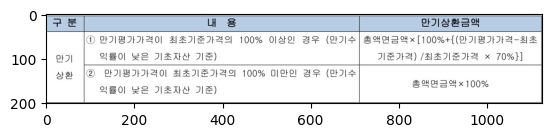

page_number: 1
==
image: ./fig/element-11.jpg, shape: (1501, 270), image_token_for_claude3: 540.36


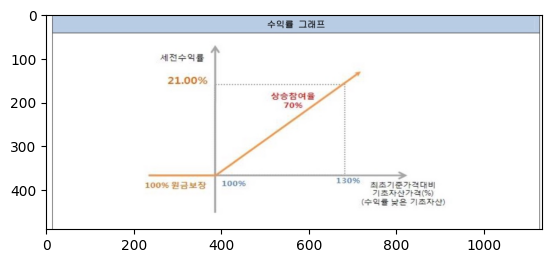

page_number: 3
==
image: ./fig/element-42.jpg, shape: (1511, 653), image_token_for_claude3: 1315.5773333333334


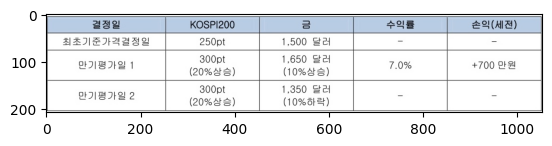

page_number: 3
==
image: ./fig/element-45.jpg, shape: (1402, 278), image_token_for_claude3: 519.6746666666667


In [19]:
docs = {}
texts = [
    Document(
        page_content=parse_output["content"]["markdown"]
    )
]

## extract_image_table
image_tmp_path = extract_image_table(
    image_path=image_path,
    file_path=file_path
)

for idx, value in enumerate(parse_output["elements"]):
      
    category = value["category"]
    markdown = value["content"]["markdown"]
    page = value["page"]
    
    if category in ["figure", "table"]:
        
        base64_encoding = value["base64_encoding"]    
        coordinates = value["coordinates"]    
        img = Image.open(BytesIO(base64.b64decode(base64_encoding)))
        plt.imshow(img)
        plt.show()
        
        # PIL로 이미지 로드
        page_img = Image.open(f'{image_tmp_path}/{page}.jpg')
        w, h = page_img.size  # PIL은 (width, height) 순서
        
        # 좌표 계산
        left = math.ceil(coordinates[0]["x"] * w)
        top = math.ceil(coordinates[0]["y"] * h)
        right = math.ceil(coordinates[1]["x"] * w)
        bottom = math.ceil(coordinates[3]["y"] * h)
        
        # PIL로 이미지 크롭
        crop_img = page_img.crop((left, top, right, bottom))
                
        crob_image_path = f'{image_path}/element-{idx}.jpg'
        crop_img.save(crob_image_path)

        print (f'page_number: {page}')
        print ("==")

        w_crop, h_crop = crop_img.size
        image_token = w_crop*h_crop/750
        print (f'image: {crob_image_path}, shape: ({w_crop}, {h_crop}), image_token_for_claude3: {image_token}' )
        
    else:
        base64_encoding= ""
        coordinates=""

    docs = postprocessing(
        docs=docs,
        page=page,
        category=category,
        markdown=markdown,
        base64_encoding=base64_encoding,
        coordinates=coordinates
    )

In [20]:
docs

{1: [{'category': 'paragraph',
   'markdown': '핵 심 설 명 서',
   'base64_encoding': '',
   'coordinates': ''},
  {'category': 'paragraph',
   'markdown': '이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여\n금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을\n충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.',
   'base64_encoding': '',
   'coordinates': ''},
  {'category': 'heading1',
   'markdown': '# 핵심설명서',
   'base64_encoding': '',
   'coordinates': ''},
  {'category': 'heading1',
   'markdown': '# [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)]',
   'base64_encoding': '',
   'coordinates': ''},
  {'category': 'heading1',
   'markdown': '# 1',
   'base64_encoding': '',
   'coordinates': ''},
  {'category': 'heading1',
   'markdown': '# 상품 개요',
   'base64_encoding': '',
   'coordinates': ''},
  {'category': 'list',
   'markdown': '- ○ 모집가액: 100 억원 (모집된 금액이 10 억 미만일 경우 발행이 취소될 수 있음)\n- ○ 기초자산: KOSPI200 지수(블룸버그 Ticker: KOSPI2 index),\n- 금가격지수 (블룸버그 Ticker: GOLDLNPM index)\n- ○ 청약기간 : 2011 년 07 월 04 일 ~2011 년 07 월 07 일 16 시\n- ○ 청약단위 : 1

### Summarization of table and image
- **Image 및 Table 내용을 text 기반으로 요약합니다.**
- **Image 및 Table이 포함된 페이지의 내용을 추가 정보로 사용하여 문맥을 고려한 요약을 합니다.**
- **이 과정은 image 및 table 정보를 embedding 기반 모델로 검색 가능하게 합니다.**
- BedrockChat with claude3: https://medium.com/@dminhk/building-with-anthropics-claude-3-on-amazon-bedrock-and-langchain-%EF%B8%8F-2b842f9c0ca8

In [21]:
import copy
from langchain.schema.output_parser import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

**요약 대상과 그에 대한 컨텍스트 정보를 구분합니다**

In [22]:
docs_for_summary = []
for page, elements in docs.items():
    
    elements = [element for element in elements if element["category"] != "footer"]
    print (f'page: {page}, # elements: {len(elements)}')
    
    for idx, element in enumerate(elements):
        
        category, markdown = element["category"], element["markdown"]
        print (f'element idx: {idx}, category: {element["category"]}')
        
        elements_copy = copy.deepcopy(elements)
        if category in ("figure", "table"):  
            
            summary_target = elements_copy.pop(idx)
            contexts_markdown = '\n'.join([context["markdown"] for context in elements_copy])
            docs_for_summary.append(
                {
                    "target_category": summary_target["category"],
                    "target_base64": summary_target["base64_encoding"],
                    "target_markdown": summary_target["markdown"],
                    "contexts_markdown": contexts_markdown
                }
            )

page: 1, # elements: 17
element idx: 0, category: paragraph
element idx: 1, category: paragraph
element idx: 2, category: heading1
element idx: 3, category: heading1
element idx: 4, category: heading1
element idx: 5, category: heading1
element idx: 6, category: list
element idx: 7, category: heading1
element idx: 8, category: heading1
element idx: 9, category: list
element idx: 10, category: heading1
element idx: 11, category: table
element idx: 12, category: paragraph
element idx: 13, category: heading1
element idx: 14, category: paragraph
element idx: 15, category: list
element idx: 16, category: list
page: 2, # elements: 22
element idx: 0, category: paragraph
element idx: 1, category: paragraph
element idx: 2, category: heading1
element idx: 3, category: heading1
element idx: 4, category: paragraph
element idx: 5, category: paragraph
element idx: 6, category: heading1
element idx: 7, category: paragraph
element idx: 8, category: paragraph
element idx: 9, category: list
element idx: 

In [23]:
docs_for_summary

[{'target_category': 'table',
  'target_base64': '/9j/2wCEAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgoBAgICAgICBQMDBQoHBgcKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCv/AABEIAMoEZgMBIgACEQEDEQH/xAGiAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgsQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2drh4uPk5ebn6Onq8fLz9PX29/j5+gEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoLEQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2gAMAwEAAhEDEQA/AP0jP7b/APwUfCCRv2XfgiQWIGPi9rHbH/UC56jmk/4bk/4KPAYX9lz4Jf8Ah3dY/wDlFU8n/Hon/XV/5LUQODmvqVlWDa2f3nz7zLFJ9PuE/wCG5P8Ago8P+bXvgif+6u6x/wDKKhv24/8Ago+P+bXPgl/4d7WP/lFXzP

**정보를 요약합니다**

In [24]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import botocore
from src.utils.common_utils import retry
from botocore.exceptions import ClientError

In [25]:
system_prompt = "You are an assistant tasked with describing table and image."
system_message_template = SystemMessagePromptTemplate.from_template(system_prompt)

human_prompt = [
    {
        "type": "image_url",
        "image_url": {
            "url": "data:image/png;base64," + "{image_base64}",
        },
    },
    {
        "type": "text",
        "text": '''
                 <contexts>
                 {contexts}
                 </contexts>
                 
                 주어진 이미지 또는 테이블을 자세히 분석하고 주어진 contexts를 참고하여 다음 정보를 추출해주세요:
                 
                 1. <title> 태그 안의 제목을 정확히 제시해주세요.
                 2. <summary> 태그 안의 내용을 요약해주세요.
                 3. <entities> 태그 안의 모든 항목을 나열하고, 각 항목에 대한 간단한 설명을 제공해주세요.
                 4. <hypothetical_questions> 태그 안의 질문들을 모두 나열해주세요.
                모든 정보는 원본 내용을 정확히 반영하되, 필요한 경우 약간의 추가 설명을 덧붙여 이해를 돕도록 해주세요.
        '''
    },
]
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

In [26]:
prompt = ChatPromptTemplate.from_messages(
    [
        system_message_template,
        human_message_template
    ]
)

summarize_chain = prompt | llm_text | StrOutputParser()

In [27]:
@retry(total_try_cnt=5, sleep_in_sec=60, retryable_exceptions=(ClientError,))
def summary_img(summarize_chain, image_base64, contexts):

    img = Image.open(BytesIO(base64.b64decode(image_base64)))
    plt.imshow(img)
    plt.show()

    stream = summarize_chain.stream(
        {
            "image_base64": image_base64,
            "contexts": contexts
        }
    )
    response = ""
    for chunk in stream: response += chunk

    return response

INFO:retry-bedrock-invocation:trying summary_img() [1/5]


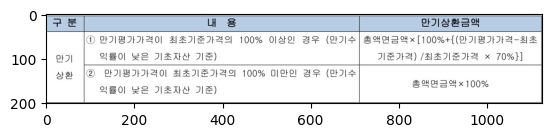

The image shows a table in Korean that describes calculation methods for maturity settlement amounts. The table has three columns labeled "구 분" (Category), "내 용" (Content), and "만기상환금액" (Maturity Settlement Amount). The table specifically details two scenarios for maturity settlement calculations.

Based on the provided context information:

## 1. Title
미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)

## 2. Summary
이 상품은 원금보장형 파생결합증권으로, KOSPI200 지수와 금가격지수를 기초자산으로 하는 금융상품입니다. 만기 1년(2011년 7월 8일 발행, 2012년 7월 9일 만기)으로 설계되었으며, 만기 시 기초자산의 성과에 따라 수익이 결정됩니다. 원금은 100% 보장되며, 기초자산이 상승할 경우 추가 수익을 얻을 수 있는 구조입니다.

## 3. Entities
- KOSPI200 지수: 한국 주식시장의 대표 지수로, 이 상품의 기초자산 중 하나
- 금가격지수(GOLDLNPM index): 금 가격을 나타내는 지수로, 이 상품의 다른 기초자산
- 최초기준가격: 2011년 7월 7일의 종가로 결정됨
- 만기평가가격: 2012년 7월 3일의 종가로 평가됨
- 만기수익률: (만기평가가격-최초기준가격)/최초기준가격 공식으로 계산됨
- 원금보장: 기초자산의 성과와 관계없이 원금은 100% 보장됨
- 만기상환금액: 기초자산의 성과에 따라 원금 또는 원금+추가수익으로 구성됨

## 4. Hypothetical Questions
- 두 기초자산 모두 상승했을 때 투자자의 수익률은 어떻게 계산되나요?
- 두 기초자산 중 하나만 하락했을 경우 투자수익은 어떻게 되나요

INFO:retry-bedrock-invocation:in retry(), summary_img() returned 'The image shows a table in Korean that describes calculation methods for maturity settlement amounts. The table has three columns labeled "구 분" (Category), "내 용" (Content), and "만기상환금액" (Maturity Settlement Amount). The table specifically details two scenarios for maturity settlement calculations.

Based on the provided context information:

## 1. Title
미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)

## 2. Summary
이 상품은 원금보장형 파생결합증권으로, KOSPI200 지수와 금가격지수를 기초자산으로 하는 금융상품입니다. 만기 1년(2011년 7월 8일 발행, 2012년 7월 9일 만기)으로 설계되었으며, 만기 시 기초자산의 성과에 따라 수익이 결정됩니다. 원금은 100% 보장되며, 기초자산이 상승할 경우 추가 수익을 얻을 수 있는 구조입니다.

## 3. Entities
- KOSPI200 지수: 한국 주식시장의 대표 지수로, 이 상품의 기초자산 중 하나
- 금가격지수(GOLDLNPM index): 금 가격을 나타내는 지수로, 이 상품의 다른 기초자산
- 최초기준가격: 2011년 7월 7일의 종가로 결정됨
- 만기평가가격: 2012년 7월 3일의 종가로 평가됨
- 만기수익률: (만기평가가격-최초기준가격)/최초기준가격 공식으로 계산됨
- 원금보장: 기초자산의 성과와 관계없이 원금은 100% 보장됨
- 만기상환금액: 기초자산의 성과에 따라 원금 또는 원금+추가수익으로 구성됨

## 4. Hypothetical Questions
- 두 기초자산 모


==
0


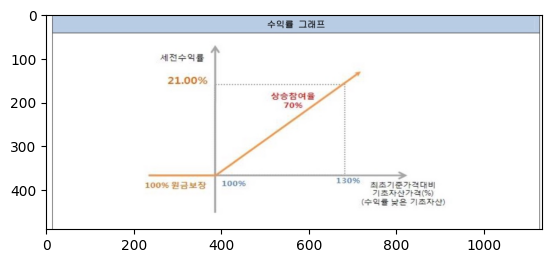

I'll analyze the image and context information provided.

<title>수익률 그래프</title>

<summary>
이 그래프는 금융상품의 손익구조를 보여주는 수익률 그래프입니다. 원금보장 100%를 기준으로, 기초자산(KOSPI200과 금가격)의 가격 변동에 따른 투자 수익률을 나타내고 있습니다. 그래프에 따르면 기초자산가격대비 130%까지 상승할 경우 최대 21.00%의 수익률을 얻을 수 있으며, 상승참여율은 70%입니다. 이는 핵심설명서의 일부로 금융소비자의 권익 보호와 금융상품 이해를 돕기 위해 제공됩니다.
</summary>

<entities>
1. 수익률 그래프 - 금융상품의 손익구조를 시각적으로 표현한 그래프
2. 100% 원금보장 - 최소한 투자 원금은 보장됨을 나타냄
3. 21.00% - 이 금융상품에서 얻을 수 있는 최대 수익률
4. 상승참여율 70% - 기초자산 상승 시 투자자가 참여하는 수익률 비율
5. 130% - 기초자산가격 상승 시 최대 수익을 얻을 수 있는 기준점
6. KOSPI200 - 투자상품의 기초자산 중 하나
7. 금가격지수 - 투자상품의 기초자산 중 하나
</entities>

<hypothetical_questions>
1. 기초자산가격이 130% 이상 상승하면 수익률은 어떻게 변화하나요?
2. 원금보장은 어떤 조건에서도 유지되나요?
3. 상승참여율 70%의 의미는 무엇인가요?
4. KOSPI200과 금가격이 모두 상승했을 때와 하나만 상승했을 때의 수익률 차이는 어떻게 되나요?
5. 이 금융상품의 최대 손실 가능성은 얼마인가요?
6. 투자 사례에 나온 것처럼 KOSPI200은 상승했지만 금가격이 하락한 경우 수익률은 어떻게 계산되나요?
</hypothetical_questions>

INFO:retry-bedrock-invocation:in retry(), summary_img() returned 'I'll analyze the image and context information provided.

<title>수익률 그래프</title>

<summary>
이 그래프는 금융상품의 손익구조를 보여주는 수익률 그래프입니다. 원금보장 100%를 기준으로, 기초자산(KOSPI200과 금가격)의 가격 변동에 따른 투자 수익률을 나타내고 있습니다. 그래프에 따르면 기초자산가격대비 130%까지 상승할 경우 최대 21.00%의 수익률을 얻을 수 있으며, 상승참여율은 70%입니다. 이는 핵심설명서의 일부로 금융소비자의 권익 보호와 금융상품 이해를 돕기 위해 제공됩니다.
</summary>

<entities>
1. 수익률 그래프 - 금융상품의 손익구조를 시각적으로 표현한 그래프
2. 100% 원금보장 - 최소한 투자 원금은 보장됨을 나타냄
3. 21.00% - 이 금융상품에서 얻을 수 있는 최대 수익률
4. 상승참여율 70% - 기초자산 상승 시 투자자가 참여하는 수익률 비율
5. 130% - 기초자산가격 상승 시 최대 수익을 얻을 수 있는 기준점
6. KOSPI200 - 투자상품의 기초자산 중 하나
7. 금가격지수 - 투자상품의 기초자산 중 하나
</entities>

<hypothetical_questions>
1. 기초자산가격이 130% 이상 상승하면 수익률은 어떻게 변화하나요?
2. 원금보장은 어떤 조건에서도 유지되나요?
3. 상승참여율 70%의 의미는 무엇인가요?
4. KOSPI200과 금가격이 모두 상승했을 때와 하나만 상승했을 때의 수익률 차이는 어떻게 되나요?
5. 이 금융상품의 최대 손실 가능성은 얼마인가요?
6. 투자 사례에 나온 것처럼 KOSPI200은 상승했지만 금가격이 하락한 경우 수익률은 어떻게 계산되나요?
</hypothetical_questions>'
INFO:retry-bedrock-invocation:trying sum


==
1


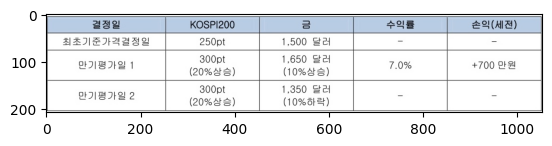

The image shows a financial product information table that outlines investment scenarios. Let me analyze the content:

# Table Analysis

The table has 5 columns labeled:
- 결정일 (Decision Date)
- KOSPI200 (Korean Stock Price Index 200)
- 금 (Gold)
- 수익률 (Return Rate)
- 손익(세전) (Profit/Loss before tax)

The table shows three scenarios:
1. 최초 기준가격 결정일 (Initial reference price determination date):
   - KOSPI200: 250pt
   - Gold: $1,500
   - No return rate or profit/loss specified

2. 만기평가일 1 (Maturity Evaluation Date 1):
   - KOSPI200: 300pt (20% increase)
   - Gold: $1,650 (10% increase)
   - Return rate: 7.0%
   - Profit/Loss: +7 million won (for a 100 million won investment)

3. 만기평가일 2 (Maturity Evaluation Date 2):
   - KOSPI200: 300pt (20% increase)
   - Gold: $1,350 (10% decrease)
   - No return rate or profit/loss specified

# Context Analysis

The context indicates this is a "핵심 설명서" (Core Explanation Document) for a financial product that aims to protect consumer rights and improve u

INFO:retry-bedrock-invocation:in retry(), summary_img() returned 'The image shows a financial product information table that outlines investment scenarios. Let me analyze the content:

# Table Analysis

The table has 5 columns labeled:
- 결정일 (Decision Date)
- KOSPI200 (Korean Stock Price Index 200)
- 금 (Gold)
- 수익률 (Return Rate)
- 손익(세전) (Profit/Loss before tax)

The table shows three scenarios:
1. 최초 기준가격 결정일 (Initial reference price determination date):
   - KOSPI200: 250pt
   - Gold: $1,500
   - No return rate or profit/loss specified

2. 만기평가일 1 (Maturity Evaluation Date 1):
   - KOSPI200: 300pt (20% increase)
   - Gold: $1,650 (10% increase)
   - Return rate: 7.0%
   - Profit/Loss: +7 million won (for a 100 million won investment)

3. 만기평가일 2 (Maturity Evaluation Date 2):
   - KOSPI200: 300pt (20% increase)
   - Gold: $1,350 (10% decrease)
   - No return rate or profit/loss specified

# Context Analysis

The context indicates this is a "핵심 설명서" (Core Explanation Document) for a fi


==
2


In [28]:
summaries = []
for idx, doc in enumerate(docs_for_summary):
    summary = summary_img(summarize_chain, doc["target_base64"], doc["contexts_markdown"])
    summaries.append(summary)
    print ("\n==")
    print (idx)

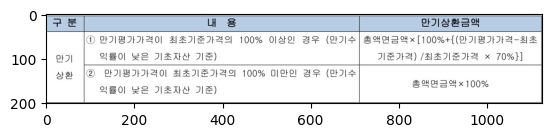

Summary: The image shows a table in Korean that describes calculation methods for maturity settlement amounts. The table has three columns labeled "구 분" (Category), "내 용" (Content), and "만기상환금액" (Maturity Settlement Amount). The table specifically details two scenarios for maturity settlement calculations.

Based on the provided context information:

## 1. Title
미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)

## 2. Summary
이 상품은 원금보장형 파생결합증권으로, KOSPI200 지수와 금가격지수를 기초자산으로 하는 금융상품입니다. 만기 1년(2011년 7월 8일 발행, 2012년 7월 9일 만기)으로 설계되었으며, 만기 시 기초자산의 성과에 따라 수익이 결정됩니다. 원금은 100% 보장되며, 기초자산이 상승할 경우 추가 수익을 얻을 수 있는 구조입니다.

## 3. Entities
- KOSPI200 지수: 한국 주식시장의 대표 지수로, 이 상품의 기초자산 중 하나
- 금가격지수(GOLDLNPM index): 금 가격을 나타내는 지수로, 이 상품의 다른 기초자산
- 최초기준가격: 2011년 7월 7일의 종가로 결정됨
- 만기평가가격: 2012년 7월 3일의 종가로 평가됨
- 만기수익률: (만기평가가격-최초기준가격)/최초기준가격 공식으로 계산됨
- 원금보장: 기초자산의 성과와 관계없이 원금은 100% 보장됨
- 만기상환금액: 기초자산의 성과에 따라 원금 또는 원금+추가수익으로 구성됨

## 4. Hypothetical Questions
- 두 기초자산 모두 상승했을 때 투자자의 수익률은 어떻게 계산되나요?
- 두 기초자산 중 하나만 하락했을 경우 투자수익

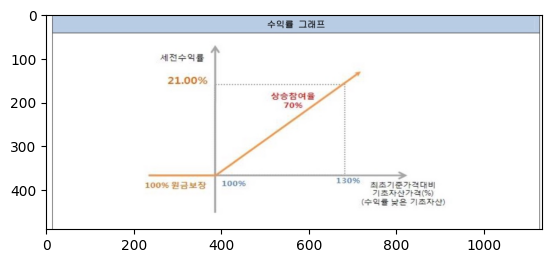

Summary: I'll analyze the image and context information provided.

<title>수익률 그래프</title>

<summary>
이 그래프는 금융상품의 손익구조를 보여주는 수익률 그래프입니다. 원금보장 100%를 기준으로, 기초자산(KOSPI200과 금가격)의 가격 변동에 따른 투자 수익률을 나타내고 있습니다. 그래프에 따르면 기초자산가격대비 130%까지 상승할 경우 최대 21.00%의 수익률을 얻을 수 있으며, 상승참여율은 70%입니다. 이는 핵심설명서의 일부로 금융소비자의 권익 보호와 금융상품 이해를 돕기 위해 제공됩니다.
</summary>

<entities>
1. 수익률 그래프 - 금융상품의 손익구조를 시각적으로 표현한 그래프
2. 100% 원금보장 - 최소한 투자 원금은 보장됨을 나타냄
3. 21.00% - 이 금융상품에서 얻을 수 있는 최대 수익률
4. 상승참여율 70% - 기초자산 상승 시 투자자가 참여하는 수익률 비율
5. 130% - 기초자산가격 상승 시 최대 수익을 얻을 수 있는 기준점
6. KOSPI200 - 투자상품의 기초자산 중 하나
7. 금가격지수 - 투자상품의 기초자산 중 하나
</entities>

<hypothetical_questions>
1. 기초자산가격이 130% 이상 상승하면 수익률은 어떻게 변화하나요?
2. 원금보장은 어떤 조건에서도 유지되나요?
3. 상승참여율 70%의 의미는 무엇인가요?
4. KOSPI200과 금가격이 모두 상승했을 때와 하나만 상승했을 때의 수익률 차이는 어떻게 되나요?
5. 이 금융상품의 최대 손실 가능성은 얼마인가요?
6. 투자 사례에 나온 것처럼 KOSPI200은 상승했지만 금가격이 하락한 경우 수익률은 어떻게 계산되나요?
</hypothetical_questions>


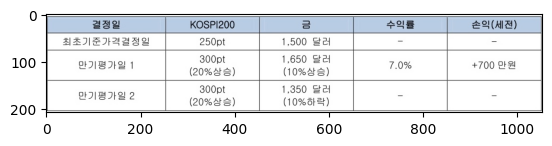

Summary: The image shows a financial product information table that outlines investment scenarios. Let me analyze the content:

# Table Analysis

The table has 5 columns labeled:
- 결정일 (Decision Date)
- KOSPI200 (Korean Stock Price Index 200)
- 금 (Gold)
- 수익률 (Return Rate)
- 손익(세전) (Profit/Loss before tax)

The table shows three scenarios:
1. 최초 기준가격 결정일 (Initial reference price determination date):
   - KOSPI200: 250pt
   - Gold: $1,500
   - No return rate or profit/loss specified

2. 만기평가일 1 (Maturity Evaluation Date 1):
   - KOSPI200: 300pt (20% increase)
   - Gold: $1,650 (10% increase)
   - Return rate: 7.0%
   - Profit/Loss: +7 million won (for a 100 million won investment)

3. 만기평가일 2 (Maturity Evaluation Date 2):
   - KOSPI200: 300pt (20% increase)
   - Gold: $1,350 (10% decrease)
   - No return rate or profit/loss specified

# Context Analysis

The context indicates this is a "핵심 설명서" (Core Explanation Document) for a financial product that aims to protect consumer rights and 

In [29]:
verbose = True
if verbose:
    for doc, summary in zip(docs_for_summary, summaries):

        print ("============================")
        img = Image.open(BytesIO(base64.b64decode(doc["target_base64"])))
        plt.imshow(img)
        plt.show()

        print (f'Summary: {summary}')

`요약`된 내용을 Document의 `page_content`로, `OCR`결과는 metadata의 `origin_image`로 사용

In [31]:
images_preprocessed = []

for doc, summary in zip(docs_for_summary, summaries):
    
    metadata = {}
    metadata["markdown"] = doc["target_markdown"]
    metadata["category"] = "Image"
    metadata["image_base64"] = doc["target_base64"]
    
    doc = Document(
        page_content=summary,
        metadata=metadata
    )
    images_preprocessed.append(doc)

In [ ]:
images_preprocessed[0]

Document(metadata={'markdown': '| 구 분 | 내 용 | 만기상환금액 |\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |\n', 'category': 'Image', 'image_base64': '/9j/2wCEAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgoBAgICAgICBQMDBQoHBgcKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCv/AABEIAMoEZgMBIgACEQEDEQH/xAGiAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgsQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2drh4uPk5ebn6Onq8fLz9PX29/j5+gEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoLEQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYm

### For tables (summary for markdown)
- 테이블의 경우 이미지 뿐만 아니라 마크다운 형태로도 가지고 있음

In [34]:
tables = [doc for doc in docs_for_summary if doc["target_category"] == "table"]

In [35]:
human_prompt = [
    {
        "type": "text",
        "text": '''
                 Here is the table: <table>{table}</table>
                 Given table, give a concise summary.
                 Don't insert any XML tag such as <table> and </table> when answering.
                 Write in Korean.
        '''
    },
]
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

In [36]:
prompt = ChatPromptTemplate.from_messages(
    [
        system_message_template,
        human_message_template
    ]
)

#summarize_chain = prompt | llm_text | StrOutputParser()
summarize_chain = {"table": lambda x:x} | prompt | llm_text | StrOutputParser()

In [37]:
table_info = [t["target_markdown"] for t in tables]
table_summaries = summarize_chain.batch(table_info, config={"max_concurrency": 1})

이 표는 만기 상환에 관한 내용을 설명하고 있습니다. 두 가지 경우로 나누어져 있습니다:

1. 만기평가가격이 최초기준가격의 100% 이상인 경우: 만기수익률이 낮은 기초자산을 기준으로 총액면금액×[100%+{(만기평가가격-최초기준가격)/최초기준가격 × 70%}]의 금액을 상환받습니다.

2. 만기평가가격이 최초기준가격의 100% 미만인 경우: 만기수익률이 낮은 기초자산을 기준으로 총액면금액×100%의 금액을 상환받습니다.

즉, 만기평가가격이 기준가격 이상이면 추가 수익이 발생하고, 미만이더라도 원금은 보장됩니다.이 표는 투자 결정에 따른 KOSPI200과 금의 가격 변화 및 수익률을 보여주고 있습니다. 

최초기준가격결정일에는 KOSPI200이 250pt, 금이 1,500 달러였습니다. 

만기평가일 1에서 KOSPI200은 300pt로 20% 상승했고, 금은 1,650 달러로 10% 상승했으며, 이때의 수익률은 7.0%로 세전 손익은 700만원의 이익이 발생했습니다. 

만기평가일 2에서는 KOSPI200이 여전히 300pt로 20% 상승 상태를 유지했지만, 금은 1,350 달러로 10% 하락했으며, 이때의 수익률과 손익은 표시되지 않았습니다.

`요약`된 내용을 Document의 `page_content`로, `parsed table`은 metadata의 `origin_table`로 사용

In [38]:
tables_preprocessed = []

for doc, summary in zip(tables, table_summaries):
    
    metadata = {}
    metadata["origin_table"] = doc["target_markdown"]
    metadata["text_as_html"] = doc["target_markdown"]
    metadata["category"] = "Table"
    metadata["image_base64"] = doc["target_base64"]
    
    doc = Document(
        page_content=summary,
        metadata=metadata
    )
    tables_preprocessed.append(doc)

In [39]:
tables_preprocessed[0]

Document(metadata={'origin_table': '| 구 분 | 내 용 | 만기상환금액 |\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |\n', 'text_as_html': '| 구 분 | 내 용 | 만기상환금액 |\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |\n', 'category': 'Table', 'image_base64': '/9j/2wCEAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgoBAgICAgICBQMDBQoHBgcKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCv/AABEIAMoEZgMBIgACEQEDEQH/xAGiAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgsQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre

0
table: | 구 분 | 내 용 | 만기상환금액 |
| --- | --- | --- |
| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |
| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |

----------------------------
summary: 이 표는 만기 상환에 관한 내용을 설명하고 있습니다. 두 가지 경우로 나누어져 있습니다:

1. 만기평가가격이 최초기준가격의 100% 이상인 경우: 만기수익률이 낮은 기초자산을 기준으로 총액면금액×[100%+{(만기평가가격-최초기준가격)/최초기준가격 × 70%}]의 금액을 상환받습니다.

2. 만기평가가격이 최초기준가격의 100% 미만인 경우: 만기수익률이 낮은 기초자산을 기준으로 총액면금액×100%의 금액을 상환받습니다.

즉, 만기평가가격이 기준가격 이상이면 추가 수익이 발생하고, 미만이더라도 원금은 보장됩니다.
----------------------------
----------------------------
image


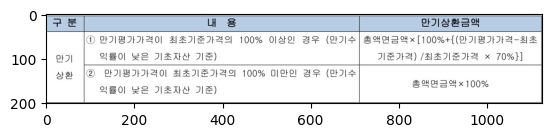

1
table: | 결정일 | KOSPI200 | 금 | 수익률 | 손익(세전) |
| --- | --- | --- | --- | --- |
| 최초기준가격결정일 | 250pt | 1,500 달러 | - | - |
| 만기평가일 1 | 300pt (20%상승) | 1,650 달러 (10%상승) | 7.0% | +700 만원 |
| 만기평가일 2 | 300pt (20%상승) | 1,350 달러 (10%하락) | - | - |

----------------------------
summary: 이 표는 투자 결정에 따른 KOSPI200과 금의 가격 변화 및 수익률을 보여주고 있습니다. 

최초기준가격결정일에는 KOSPI200이 250pt, 금이 1,500 달러였습니다. 

만기평가일 1에서 KOSPI200은 300pt로 20% 상승했고, 금은 1,650 달러로 10% 상승했으며, 이때의 수익률은 7.0%로 세전 손익은 700만원의 이익이 발생했습니다. 

만기평가일 2에서는 KOSPI200이 여전히 300pt로 20% 상승 상태를 유지했지만, 금은 1,350 달러로 10% 하락했으며, 이때의 수익률과 손익은 표시되지 않았습니다.
----------------------------
----------------------------
image


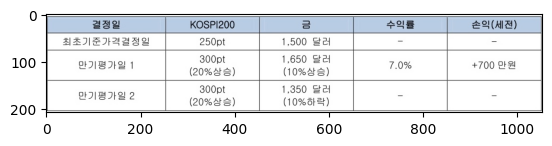

In [40]:
verbose = True
index = 0
if verbose:
    for table, summary in zip(tables, table_summaries):

        #if table_as_image:
        #page_contents, table_as_html, img_base64 = table
        category, img_base64, table_as_html, page_contents = table["target_category"], table["target_base64"], table["target_markdown"], table["target_markdown"]
        #else: page_contents, table_as_html = table

        print ("============================")
        print (index)
        print (f'table: {page_contents}')
        print ("----------------------------")
        print (f'summary: {summary}')
        print ("----------------------------")

        print ("----------------------------")
        if img_base64 is not None:
            print ("image")
            img = Image.open(BytesIO(base64.b64decode(img_base64)))
            plt.imshow(img)
            plt.show()
        index += 1


## 4. Index 생성
Document로 부터 추출한 text, table, 그리고 image 정보를 Amazon OpenSearch에 저장합니다. (인덱싱)  

### Index 이름 결정

In [41]:
import boto3
from src.utils.ssm import parameter_store

In [42]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [43]:
index_name = "complex-doc-index"

In [44]:
pm.put_params(
    key="opensearch_index_name",
    value=f'{index_name}',
    overwrite=True,
    enc=False
)

Parameter stored successfully.


### Index 스키마 정의

In [45]:
index_body = {
    'settings': {
        'analysis': {
            'analyzer': {
                'my_analyzer': {
                         'char_filter':['html_strip'],
                    'tokenizer': 'nori',
                    'filter': [
                        #'nori_number',
                        #'lowercase',
                        #'trim',
                        'my_nori_part_of_speech'
                    ],
                    'type': 'custom'
                }
            },
            'tokenizer': {
                'nori': {
                    'decompound_mode': 'mixed',
                    'discard_punctuation': 'true',
                    'type': 'nori_tokenizer'
                }
            },
            "filter": {
                "my_nori_part_of_speech": {
                    "type": "nori_part_of_speech",
                    "stoptags": [
                        "J", "XSV", "E", "IC","MAJ","NNB",
                        "SP", "SSC", "SSO",
                        "SC","SE","XSN","XSV",
                        "UNA","NA","VCP","VSV",
                        "VX"
                    ]
                }
            }
        },
        'index': {
            'knn': True,
            'knn.space_type': 'cosinesimil'  # Example space type
        }
    },
    'mappings': {
        'properties': {
            'metadata': {
                'properties': {
                    'source': {'type': 'keyword'},
                    'page_number': {'type':'long'},
                    'category': {'type':'text'},
                    'file_directory': {'type':'text'},
                    'last_modified': {'type': 'text'},
                    'type': {'type': 'keyword'},
                    'image_base64': {'type':'text'},
                    'origin_image': {'type':'text'},
                    'origin_table': {'type':'text'},
                }
            },
            'text': {
                'analyzer': 'my_analyzer',
                'search_analyzer': 'my_analyzer',
                'type': 'text'
            },
            'vector_field': {
                'type': 'knn_vector',
                'dimension': f"{dimension}" # Replace with your vector dimension
            }
        }
    }
}


## 5. LangChain OpenSearch VectorStore 생성 
### 선수 조건

#### [중요] 아래에 aws parameter store 에 아래 인증정보가 먼저 입력되어 있어야 합니다.

In [46]:
opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)

opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)

opensearch_user_password = pm.get_params(
    key="opensearch_user_password",
    enc=True
)

In [47]:
opensearch_domain_endpoint = opensearch_domain_endpoint
rag_user_name = opensearch_user_id
rag_user_password = opensearch_user_password

http_auth = (rag_user_name, rag_user_password) # Master username, Master password

### OpenSearch Client 생성

In [48]:
from src.utils.opensearch import opensearch_utils

In [49]:
aws_region = os.environ.get("AWS_DEFAULT_REGION", None)

os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

### 오픈 서치 인덱스 생성 
- 오픈 서치에 해당 인덱스가 존재하면, 삭제 합니다. 

In [50]:
index_exists = opensearch_utils.check_if_index_exists(
    os_client,
    index_name
)

if index_exists:
    opensearch_utils.delete_index(
        os_client,
        index_name
    )

opensearch_utils.create_index(os_client, index_name, index_body)
index_info = os_client.indices.get(index=index_name)
print("Index is created")
pprint(index_info)

index_name=complex-doc-index, exists=True

Deleting index:
{'acknowledged': True}

Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'complex-doc-index'}
Index is created
{'complex-doc-index': {'aliases': {},
                       'mappings': {'properties': {'metadata': {'properties': {'category': {'type': 'text'},
                                                                               'file_directory': {'type': 'text'},
                                                                               'image_base64': {'type': 'text'},
                                                                               'last_modified': {'type': 'text'},
                                                                               'origin_image': {'type': 'text'},
                                                                               'origin_table': {'type': 'text'},
                                                                               'page_nu

### 랭체인 인덱스 연결 오브젝트 생성

- [langchain.vectorstores.opensearch_vector_search.OpenSearchVectorSearch](https://api.python.langchain.com/en/latest/vectorstores/langchain.vectorstores.opensearch_vector_search.OpenSearchVectorSearch.html)

In [51]:
from langchain_community.vectorstores import OpenSearchVectorSearch

In [58]:
vector_db = OpenSearchVectorSearch(
    index_name=index_name,
    opensearch_url=opensearch_domain_endpoint,
    embedding_function=llm_emb,
    http_auth=http_auth, # http_auth
    is_aoss=False,
    engine="faiss",
    space_type="l2",
    bulk_size=100000,
    timeout=60
)
vector_db

### Chunking Strategy: Parent documents
* Chunk Size and Chunk Overlap Size

In [59]:
from src.utils.chunk import parant_documents

In [60]:
parent_chunk_size = 1024 # 4096 
parent_chunk_overlap = 0

child_chunk_size = 256 # 1024
child_chunk_overlap = 64 # 256 

opensearch_parent_key_name = "parent_id"
opensearch_family_tree_key_name = "family_tree"

* Parent Chunking
    - create_parent_chunk() 아래와 같은 작업을 합니다.
    - all_docs 에 있는 문서를 parent_chunk_size 만큼으로 청킹 합니다.
    - Parent Chunk 에 두개의 메타 데이타를 생성 합니다.
        - family_tree: parent
        - parent_id : None

In [61]:
texts[0].page_content

'핵 심 설 명 서\n\n이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여\n금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을\n충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.\n\n# 핵심설명서\n\n# [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)]\n\n# 1\n\n# 상품 개요\n\n- ○ 모집가액: 100 억원 (모집된 금액이 10 억 미만일 경우 발행이 취소될 수 있음)\n- ○ 기초자산: KOSPI200 지수(블룸버그 Ticker: KOSPI2 index),\n- 금가격지수 (블룸버그 Ticker: GOLDLNPM index)\n- ○ 청약기간 : 2011 년 07 월 04 일 ~2011 년 07 월 07 일 16 시\n- ○ 청약단위 : 100 만원 이상 100 만원 단위 (발행 후 추가 납입 불가)\n- ○ 발 행 일 : 2011 년 07 월 08 일\n- ○ 만 기 일 : 2012 년 07 월 09 일(만기 1 년)\n- ○ 상품위험등급: 4 등급\n\n\n# 2\n\n# 기준가격 결정일 및 평가방법\n\n- ○ 최초 기준가격: 2011 년 07 월 07 일의 종가(해당 거래소 기준)\n- ○ 만기 평가가격: 2012 년 07 월 03 일의 종가(해당 거래소 기준)\n\n\n# 3 손익 구조\n\n| 구 분 | 내 용 | 만기상환금액 |\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |\n\n\n※ 만기수익률=(만기평가가격-최초기준가격)/최초기준가격\n(단, {(만기평가가격-최초기준가격)/최초기준가격×70%}은 소수점 다섯째자리 이하 절사)\n\n# 

In [62]:
parent_chunk_docs = parant_documents.create_parent_chunk(
    docs=texts,
    parent_id_key=opensearch_parent_key_name,
    family_tree_id_key=opensearch_family_tree_key_name,
    parent_chunk_size=parent_chunk_size,
    parent_chunk_overlap=parent_chunk_overlap
)
print(f'Number of parent_chunk_docs= {len(parent_chunk_docs)}')

Number of parent_chunk_docs= 4


In [63]:
parent_chunk_docs

[Document(metadata={'family_tree': 'parent', 'parent_id': None}, page_content='핵 심 설 명 서\n\n이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여\n금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을\n충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.\n\n# 핵심설명서\n\n# [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)]\n\n# 1\n\n# 상품 개요\n\n- ○ 모집가액: 100 억원 (모집된 금액이 10 억 미만일 경우 발행이 취소될 수 있음)\n- ○ 기초자산: KOSPI200 지수(블룸버그 Ticker: KOSPI2 index),\n- 금가격지수 (블룸버그 Ticker: GOLDLNPM index)\n- ○ 청약기간 : 2011 년 07 월 04 일 ~2011 년 07 월 07 일 16 시\n- ○ 청약단위 : 100 만원 이상 100 만원 단위 (발행 후 추가 납입 불가)\n- ○ 발 행 일 : 2011 년 07 월 08 일\n- ○ 만 기 일 : 2012 년 07 월 09 일(만기 1 년)\n- ○ 상품위험등급: 4 등급\n\n\n# 2\n\n# 기준가격 결정일 및 평가방법\n\n- ○ 최초 기준가격: 2011 년 07 월 07 일의 종가(해당 거래소 기준)\n- ○ 만기 평가가격: 2012 년 07 월 03 일의 종가(해당 거래소 기준)\n\n\n# 3 손익 구조\n\n| 구 분 | 내 용 | 만기상환금액 |\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |\n\n\n※ 만기수익률=(만

* Insert doc into OpenSearch 

In [64]:
%%time

parent_ids = vector_db.add_documents(
    documents = parent_chunk_docs, 
    vector_field = "vector_field",
    bulk_size = 1000000
)

CPU times: user 87.9 ms, sys: 3.25 ms, total: 91.2 ms
Wall time: 899 ms


In [65]:
parent_chunk_docs

[Document(metadata={'family_tree': 'parent', 'parent_id': None}, page_content='핵 심 설 명 서\n\n이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여\n금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을\n충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.\n\n# 핵심설명서\n\n# [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)]\n\n# 1\n\n# 상품 개요\n\n- ○ 모집가액: 100 억원 (모집된 금액이 10 억 미만일 경우 발행이 취소될 수 있음)\n- ○ 기초자산: KOSPI200 지수(블룸버그 Ticker: KOSPI2 index),\n- 금가격지수 (블룸버그 Ticker: GOLDLNPM index)\n- ○ 청약기간 : 2011 년 07 월 04 일 ~2011 년 07 월 07 일 16 시\n- ○ 청약단위 : 100 만원 이상 100 만원 단위 (발행 후 추가 납입 불가)\n- ○ 발 행 일 : 2011 년 07 월 08 일\n- ○ 만 기 일 : 2012 년 07 월 09 일(만기 1 년)\n- ○ 상품위험등급: 4 등급\n\n\n# 2\n\n# 기준가격 결정일 및 평가방법\n\n- ○ 최초 기준가격: 2011 년 07 월 07 일의 종가(해당 거래소 기준)\n- ○ 만기 평가가격: 2012 년 07 월 03 일의 종가(해당 거래소 기준)\n\n\n# 3 손익 구조\n\n| 구 분 | 내 용 | 만기상환금액 |\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |\n\n\n※ 만기수익률=(만

In [66]:
total_count_docs = opensearch_utils.get_count(os_client, index_name)
print("total count docs: ", total_count_docs)

total count docs:  {'count': 4, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}}


* 삽입된 Parent Chunk 의 첫번째를 확인 합니다. family_tree, parent_id 의 값을 확인 하세요.
    - family_tree 가 parent의 경우, parent_id는 None입니다. (child가 속한 parent가 무엇인지 알려주는 용도기 때문)

In [70]:
def show_opensearch_doc_info(response):
    print("opensearch document id:" , response["_id"])
    print("family_tree:" , response["_source"]["metadata"]["family_tree"])
    print("parent document id:" , response["_source"]["metadata"]["parent_id"])
    print("parent document text: \n" , response["_source"]["text"])

response = opensearch_utils.get_document(os_client, doc_id = parent_ids[0], index_name = index_name)
show_opensearch_doc_info(response)

opensearch document id: d197c7e3-a3e7-4976-9cc5-fb7fc60fe67c
family_tree: parent
parent document id: None
parent document text: 
 핵 심 설 명 서

이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여
금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을
충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.

# 핵심설명서

# [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)]

# 1

# 상품 개요

- ○ 모집가액: 100 억원 (모집된 금액이 10 억 미만일 경우 발행이 취소될 수 있음)
- ○ 기초자산: KOSPI200 지수(블룸버그 Ticker: KOSPI2 index),
- 금가격지수 (블룸버그 Ticker: GOLDLNPM index)
- ○ 청약기간 : 2011 년 07 월 04 일 ~2011 년 07 월 07 일 16 시
- ○ 청약단위 : 100 만원 이상 100 만원 단위 (발행 후 추가 납입 불가)
- ○ 발 행 일 : 2011 년 07 월 08 일
- ○ 만 기 일 : 2012 년 07 월 09 일(만기 1 년)
- ○ 상품위험등급: 4 등급


# 2

# 기준가격 결정일 및 평가방법

- ○ 최초 기준가격: 2011 년 07 월 07 일의 종가(해당 거래소 기준)
- ○ 만기 평가가격: 2012 년 07 월 03 일의 종가(해당 거래소 기준)


# 3 손익 구조

| 구 분 | 내 용 | 만기상환금액 |
| --- | --- | --- |
| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |
| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |



* Child Chunking
    - 아래의 create_child_chunk() 는 다음과 같은 작업을 합니다.
    - parent_chunk_docs 각각에 대해서 Child Chunk 를 생성 합니다. 
    - Child Chunk 에 두개의 메타 데이타를 생성 합니다.
        - family_tree: child
        - parent_id : parent 에 대한 OpenSearch document id

In [71]:
child_chunk_docs = parant_documents.create_child_chunk(
    child_chunk_size=child_chunk_size,
    child_chunk_overlap=child_chunk_overlap,
    docs=parent_chunk_docs,
    parent_ids_value=parent_ids,
    parent_id_key=opensearch_parent_key_name,
    family_tree_id_key=opensearch_family_tree_key_name
)

print(f"Number of child_chunk_docs= {len(child_chunk_docs)}")

Number of child_chunk_docs= 18


In [72]:
child_chunk_docs[0]

Document(metadata={'family_tree': 'child', 'parent_id': 'd197c7e3-a3e7-4976-9cc5-fb7fc60fe67c'}, page_content='핵 심 설 명 서\n\n이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여\n금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을\n충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.\n\n# 핵심설명서\n\n# [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)]\n\n# 1\n\n# 상품 개요')

In [73]:
parent_id = child_chunk_docs[0].metadata["parent_id"]
print("child's parent_id: ", parent_id)
print("\n###### Search parent in OpenSearch")
response = opensearch_utils.get_document(os_client, doc_id = parent_id, index_name = index_name)
show_opensearch_doc_info(response)    

child's parent_id:  d197c7e3-a3e7-4976-9cc5-fb7fc60fe67c

###### Search parent in OpenSearch
opensearch document id: d197c7e3-a3e7-4976-9cc5-fb7fc60fe67c
family_tree: parent
parent document id: None
parent document text: 
 핵 심 설 명 서

이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여
금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을
충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.

# 핵심설명서

# [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)]

# 1

# 상품 개요

- ○ 모집가액: 100 억원 (모집된 금액이 10 억 미만일 경우 발행이 취소될 수 있음)
- ○ 기초자산: KOSPI200 지수(블룸버그 Ticker: KOSPI2 index),
- 금가격지수 (블룸버그 Ticker: GOLDLNPM index)
- ○ 청약기간 : 2011 년 07 월 04 일 ~2011 년 07 월 07 일 16 시
- ○ 청약단위 : 100 만원 이상 100 만원 단위 (발행 후 추가 납입 불가)
- ○ 발 행 일 : 2011 년 07 월 08 일
- ○ 만 기 일 : 2012 년 07 월 09 일(만기 1 년)
- ○ 상품위험등급: 4 등급


# 2

# 기준가격 결정일 및 평가방법

- ○ 최초 기준가격: 2011 년 07 월 07 일의 종가(해당 거래소 기준)
- ○ 만기 평가가격: 2012 년 07 월 03 일의 종가(해당 거래소 기준)


# 3 손익 구조

| 구 분 | 내 용 | 만기상환금액 |
| --- | --- | --- |
| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최

### Manipulate table and image for parent documents
- set family_tree of table and image documents as "parent_table" and these kinds of types are included in searchable list (child, parent_table and parent_image) in parant document strategy.

In [74]:
for table in tables_preprocessed:
    table.metadata["family_tree"], table.metadata["parent_id"] = "parent_table", "NA"

In [75]:
for image in images_preprocessed:
    image.metadata["family_tree"], image.metadata["parent_id"] = "parent_image", "NA"

In [76]:
images_preprocessed

[Document(metadata={'markdown': '| 구 분 | 내 용 | 만기상환금액 |\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |\n', 'category': 'Image', 'image_base64': '/9j/2wCEAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgoBAgICAgICBQMDBQoHBgcKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCv/AABEIAMoEZgMBIgACEQEDEQH/xAGiAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgsQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2drh4uPk5ebn6Onq8fLz9PX29/j5+gEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoLEQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeY

### Merge text, table and image

In [77]:
from itertools import chain

In [78]:
docs_preprocessed = list(chain(child_chunk_docs, tables_preprocessed, images_preprocessed))

* Insert doc into OpenSearch

In [79]:
%%time

child_ids = vector_db.add_documents(
    documents=docs_preprocessed, 
    vector_field = "vector_field",
    bulk_size=1000000
)

print("length of child_ids: ", len(child_ids))

length of child_ids:  23
CPU times: user 88.4 ms, sys: 2.35 ms, total: 90.8 ms
Wall time: 2.69 s


## 6. 검색 테스트

In [80]:
from src.utils.agentic_rag import rag_chain, OpenSearchHybridSearchRetriever
from src.utils.agentic_rag import show_context_used

In [81]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # hybird-search debugger
    #hybrid_search_debugger = "semantic", #[semantic, lexical, None]
    
    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=False, # enable reranker with reranker model
    #reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document=True, # enable parent document
    
    # option for complex pdf consisting of text, table and image
    complex_doc=True,
    
    # option for async search
    async_mode=True,

    # option for output
    k=2, # 최종 Document 수 정의
    verbose=False,

)

### 하이브리드 검색

In [82]:
%%time
query = "만기상환 여부에 따른 투자 수익률"
search_hybrid_result, tables, images = opensearch_hybrid_retriever.invoke(query)

CPU times: user 14.7 ms, sys: 949 μs, total: 15.6 ms
Wall time: 114 ms



-----------------------------------------------
1. Category: Table, Chunk: 291 Characters
-----------------------------------------------


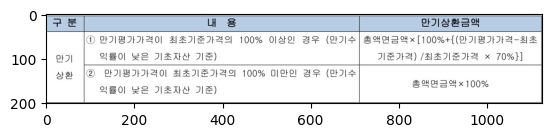

이 표는 만기 상환에 관한 내용을 설명하고 있습니다. 두 가지 경우로 나누어져 있습니다:

1. 만기평가가격이 최초기준가격의 100% 이상인 경우: 만기수익률이 낮은 기초자산을 기준으로 총액면금액×[100%+{(만기평가가격-최초기준가격)/최초기준가격 × 70%}]의
금액을 상환받습니다.

2. 만기평가가격이 최초기준가격의 100% 미만인 경우: 만기수익률이 낮은 기초자산을 기준으로 총액면금액×100%의 금액을 상환받습니다.

즉, 만기평가가격이 기준가격 이상이면 추가 수익이 발생하고, 미만이더라도 원금은 보장됩니다.


metadata:
 {'origin_table': '| 구 분 | 내 용 | 만기상환금액 |\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인
경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이
최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |\n', 'text_as_html': '| 구 분 | 내 용 | 만기상환금액
|\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) |
총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은
기초자산 기준) | 총액면금액×100% |\n', 'category': 'Table', 'image_base64': '', 'family_tree': 'parent_table',
'parent_id': 'NA', 'id': '854da525-94fc-4d55-9da7-29c6da433979', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
2. Chunk: 981 Characters
-----------------------------------------------
핵 심 설 명 서

이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여
금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을
충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.

# 핵심설명서

# [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)]

# 1



In [83]:
show_context_used(search_hybrid_result)

### RAG

In [84]:
from textwrap import dedent

In [85]:
system_prompt = dedent(
    """
    You are a master answer bot designed to answer user's questions.
    I'm going to give you contexts which consist of texts, tables and images.
    Read the contexts carefully, because I'm going to ask you a question about it.
    """
)

human_prompt = dedent(
    """
    Here is the contexts as texts: <contexts>{contexts}</contexts>

    First, find a few paragraphs or sentences from the contexts that are most relevant to answering the question.
    Then, answer the question as much as you can.

    Skip the preamble and go straight into the answer.
    Don't insert any XML tag such as <contexts> and </contexts> when answering.
    Answer in Korean.

    Here is the question: <question>{question}</question>

    If the question cannot be answered by the contexts, say "No relevant contexts".
    """
)

In [86]:
qa = rag_chain(
    llm_text=llm_text,
    retriever=opensearch_hybrid_retriever,
    system_prompt=system_prompt,
    human_prompt=human_prompt,
    return_context=True,
    verbose=False,
)

In [87]:
query = "만기상환 여부에 따른 투자 수익률"

response, contexts = qa.invoke(
    query = query
)

verbose False
만기상환 시 투자 수익률은 다음과 같이 두 가지 경우로 나뉩니다:

1. 만기평가가격이 최초기준가격의 100% 이상인 경우:
   - 만기수익률이 낮은 기초자산을 기준으로
   - 총액면금액 × [100% + {(만기평가가격-최초기준가격)/최초기준가격 × 70%}]의 금액을 상환받습니다.
   - 즉, 원금(100%)에 추가로 상승률의 70%를 참여율로 적용한 수익이 발생합니다.

2. 만기평가가격이 최초기준가격의 100% 미만인 경우:
   - 만기수익률이 낮은 기초자산을 기준으로
   - 총액면금액 × 100%의 금액을 상환받습니다.
   - 즉, 원금(100%)만 보장되어 돌려받게 됩니다.

이 상품은 원금보장형 DLS로, 기초자산의 가격이 하락하더라도 원금은 보장되며, 기초자산 가격이 상승하면 그 상승률의 일부(70%)를 추가 수익으로 얻을 수 있습니다.


-----------------------------------------------
1. Category: Table, Chunk: 291 Characters
-----------------------------------------------


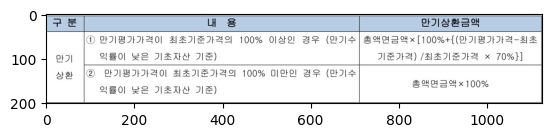

이 표는 만기 상환에 관한 내용을 설명하고 있습니다. 두 가지 경우로 나누어져 있습니다:

1. 만기평가가격이 최초기준가격의 100% 이상인 경우: 만기수익률이 낮은 기초자산을 기준으로 총액면금액×[100%+{(만기평가가격-최초기준가격)/최초기준가격 × 70%}]의
금액을 상환받습니다.

2. 만기평가가격이 최초기준가격의 100% 미만인 경우: 만기수익률이 낮은 기초자산을 기준으로 총액면금액×100%의 금액을 상환받습니다.

즉, 만기평가가격이 기준가격 이상이면 추가 수익이 발생하고, 미만이더라도 원금은 보장됩니다.


metadata:
 {'origin_table': '| 구 분 | 내 용 | 만기상환금액 |\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인
경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이
최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |\n', 'text_as_html': '| 구 분 | 내 용 | 만기상환금액
|\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) |
총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은
기초자산 기준) | 총액면금액×100% |\n', 'category': 'Table', 'image_base64': '', 'family_tree': 'parent_table',
'parent_id': 'NA', 'id': '854da525-94fc-4d55-9da7-29c6da433979', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
2. Chunk: 981 Characters
-----------------------------------------------
핵 심 설 명 서

이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여
금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을
충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.

# 핵심설명서

# [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)]

# 1



In [88]:
show_context_used(contexts)

# SageMaker Processing Job 이용하기

## 1. scripy 만들기

In [ ]:
%%writefile ./src/preprocessing.py

import os
import json
import copy
import boto3
import shutil
import argparse
from pprint import pprint
from utils import bedrock
from itertools import chain
from utils.bedrock import bedrock_info

from langchain_aws import ChatBedrock
from langchain_aws import BedrockEmbeddings
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

import math
import base64
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from langchain.schema import Document
from pdf2image import convert_from_path
from requests_toolbelt import MultipartEncoder

import botocore
from utils.common_utils import retry
from langchain.schema.output_parser import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

from utils.chunk import parant_documents
from utils.opensearch import opensearch_utils
from langchain_community.vectorstores import OpenSearchVectorSearch

class preprocess():
    
    def __init__(self, args):
        
        self.args = args
        self.proc_prefix = self.args.proc_prefix #'/opt/ml/processing'
        
        self.input_dir = os.path.join(self.proc_prefix, "input")
        self.output_dir = os.path.join(self.proc_prefix, "output")
        os.makedirs(self.input_dir, exist_ok=True)
        os.makedirs(self.output_dir, exist_ok=True)
        
        print (os.listdir(self.input_dir))
        
        ############# 수정
        #self.file_path = os.path.join(self.input_dir, "sample-2.pdf")
        self.file_path = os.path.join(self.input_dir, self.args.file_name)
        #"./data/complex_pdf/sample-2.pdf"
        ###############
        
    def _initialization(self, ):
        
        self.boto3_bedrock = bedrock.get_bedrock_client(
            assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
            endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
            region=os.environ.get("AWS_DEFAULT_REGION", None),
        )
        
        self.llm_text = ChatBedrock(
            model_id=bedrock_info.get_model_id(model_name="Claude-V3-5-Sonnet"),
            client=self.boto3_bedrock,
            streaming=True,
            callbacks=[StreamingStdOutCallbackHandler()],
            model_kwargs={
                "max_tokens": 2048,
                "stop_sequences": ["\n\nHuman"],
            }
        )
        
        self.llm_emb = BedrockEmbeddings(
            client=self.boto3_bedrock,
            model_id=bedrock_info.get_model_id(model_name="Titan-Text-Embeddings-V2")
        )
        self.dimension = 1024
        
    def _document_parsing(self, ):
        
        runtime_sm_client = boto3.client('runtime.sagemaker')

        # Prepare multipart form data
        encoder = MultipartEncoder(
            fields={
                'document': (os.path.basename(self.file_path), open(self.file_path, 'rb'), 'application/pdf'),
                'model': 'document-parse',
                'ocr': 'auto',
                'coordinates': 'true',
                'output_formats': '["markdown"]', #'["text", "html", "markdown"]',
                'base64_encoding': '["table", "figure"]'
            }
        )

        # Get the raw bytes of the multipart form data
        body = encoder.to_string()

        response = runtime_sm_client.invoke_endpoint(
            EndpointName=self.args.endpoint_document_parser,
            ContentType=encoder.content_type,  # This will be 'multipart/form-data; boundary=...'
            Body=body
        )

        result = response["Body"].read()
        parse_output = json.loads(result)
        
        return parse_output
    
    def _extract_image_table(self, parse_output):
        
        def processing(**kwargs):
    
            category = kwargs["category"]
            markdown = kwargs["markdown"]
            base64_encoding = kwargs["base64_encoding"]
            coordinates = kwargs["coordinates"]
            page = kwargs["page"]
            docs = kwargs["docs"]

            if page in docs: 
                docs[page].append(
                    {
                        "category": category,
                         "markdown": markdown,
                         "base64_encoding": base64_encoding,
                         "coordinates": coordinates
                    }
                )
            else:
                docs[page] = [
                    {
                        "category": category,
                        "markdown": markdown,
                        "base64_encoding": base64_encoding,
                        "coordinates": coordinates
                    }
                ]

            return docs

        def image_conversion(**kwargs):

            image_path = kwargs["image_path"]
            file_path = kwargs["file_path"]

            image_tmp_path = os.path.join(image_path, "tmp")
            if os.path.isdir(image_tmp_path): shutil.rmtree(image_tmp_path)
            os.mkdir(image_tmp_path)

            # from pdf to image
            pages = convert_from_path(file_path)
            for i, page in enumerate(pages):
                print (f'pdf page {i}, size: {page.size}')    
                page.save(f'{image_tmp_path}/{str(i+1)}.jpg', "JPEG")

            return image_tmp_path
        
        image_path = os.path.join(self.input_dir, "fig")
        if os.path.isdir(image_path): shutil.rmtree(image_path)
        os.mkdir(image_path)
        
        docs = {}
        texts = [
            Document(
                page_content=parse_output["content"]["markdown"]
            )
        ]

        ## extract_image_table
        image_tmp_path = image_conversion(
            image_path=image_path,
            file_path=self.file_path
        )

        for idx, value in enumerate(parse_output["elements"]):

            category = value["category"]
            markdown = value["content"]["markdown"]
            page = value["page"]

            if category in ["figure", "table"]:

                base64_encoding = value["base64_encoding"]    
                coordinates = value["coordinates"]    
                img = Image.open(BytesIO(base64.b64decode(base64_encoding)))
                plt.imshow(img)
                plt.show()

                page_img = Image.open(f'{image_tmp_path}/{page}.jpg')
                w, h = page_img.size  # PIL은 (width, height) 순서

                # 좌표 계산
                left = math.ceil(coordinates[0]["x"] * w)
                top = math.ceil(coordinates[0]["y"] * h)
                right = math.ceil(coordinates[1]["x"] * w)
                bottom = math.ceil(coordinates[3]["y"] * h)

                # PIL로 이미지 크롭
                crop_img = page_img.crop((left, top, right, bottom))
                        
                crob_image_path = f'{image_path}/element-{idx}.jpg'
                crop_img.save(crob_image_path)

                w_crop, h_crop = crop_img.size
                image_token = w_crop*h_crop/750
                print (f'image: {crob_image_path}, shape: ({w_crop}, {h_crop}), image_token_for_claude3: {image_token}' )
                
            else:
                base64_encoding= ""
                coordinates=""

            docs = processing(
                docs=docs,
                page=page,
                category=category,
                markdown=markdown,
                base64_encoding=base64_encoding,
                coordinates=coordinates
            )
            
        return docs, texts
    
    def _context_generation_for_image(self, docs):
        
        def manipulate_docs_for_summary(docs):
            
            docs_for_summary = []
            for page, elements in docs.items():

                elements = [element for element in elements if element["category"] != "footer"]
                print (f'page: {page}, # elements: {len(elements)}')

                for idx, element in enumerate(elements):

                    category, markdown = element["category"], element["markdown"]
                    print (f'element idx: {idx}, category: {element["category"]}')

                    elements_copy = copy.deepcopy(elements)
                    if category in ("figure", "table"):  
                        
                        summary_target = elements_copy.pop(idx)
                        contexts_markdown = '\n'.join([context["markdown"] for context in elements_copy])
                        docs_for_summary.append(
                            {
                                "target_category": summary_target["category"],
                                "target_base64": summary_target["base64_encoding"],
                                "target_markdown": summary_target["markdown"],
                                "contexts_markdown": contexts_markdown
                            }
                        )
                
            return docs_for_summary
        
        def get_summary_chain():
            
            system_prompt = "You are an assistant tasked with describing table and image."
            system_message_template = SystemMessagePromptTemplate.from_template(system_prompt)

            human_prompt = [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": "data:image/png;base64," + "{image_base64}",
                    },
                },
                {
                    "type": "text",
                    "text": '''
                             <contexts>
                             {contexts}
                             </contexts>

                             주어진 이미지 또는 테이블을 자세히 분석하고 주어진 contexts를 참고하여 다음 정보를 추출해주세요:

                             1. <title> 태그 안의 제목을 정확히 제시해주세요.
                             2. <summary> 태그 안의 내용을 요약해주세요.
                             3. <entities> 태그 안의 모든 항목을 나열하고, 각 항목에 대한 간단한 설명을 제공해주세요.
                             4. <hypothetical_questions> 태그 안의 질문들을 모두 나열해주세요.
                            모든 정보는 원본 내용을 정확히 반영하되, 필요한 경우 약간의 추가 설명을 덧붙여 이해를 돕도록 해주세요.
                    '''
                },
            ]
            human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)
            
            prompt = ChatPromptTemplate.from_messages(
                [
                    system_message_template,
                    human_message_template
                ]
            )

            summarize_chain = prompt | self.llm_text | StrOutputParser()
            
            return summarize_chain
        
        @retry(total_try_cnt=5, sleep_in_sec=10, retryable_exceptions=(botocore.exceptions.EventStreamError))
        def summary_img(summarize_chain, image_base64, contexts):

            img = Image.open(BytesIO(base64.b64decode(image_base64)))
            plt.imshow(img)
            plt.show()

            stream = summarize_chain.stream(
                {
                    "image_base64": image_base64,
                    "contexts": contexts
                }
            )
            response = ""
            for chunk in stream: response += chunk

            return response
            
        docs_for_summary = manipulate_docs_for_summary(docs)
        
        print ("docs_for_summary", len(docs_for_summary))
        
        
        summarize_chain = get_summary_chain()
        
        summaries = []
        for idx, doc in enumerate(docs_for_summary):
            summary = summary_img(summarize_chain, doc["target_base64"], doc["contexts_markdown"])
            summaries.append(summary)
            print ("\n==")
            print (idx)
            
        images_preprocessed = []
        for doc, summary in zip(docs_for_summary, summaries):

            metadata = {}
            metadata["markdown"] = doc["target_markdown"]
            metadata["category"] = "Image"
            metadata["image_base64"] = doc["target_base64"]

            doc = Document(
                page_content=summary,
                metadata=metadata
            )
            images_preprocessed.append(doc)
            
        for image in images_preprocessed:
            image.metadata["family_tree"], image.metadata["parent_id"] = "parent_image", "NA"
        
        return images_preprocessed, docs_for_summary

    def _context_generation_for_table(self, docs_for_summary):
        
        def get_summary_chain():
            
            system_prompt = "You are an assistant tasked with describing table and image."
            system_message_template = SystemMessagePromptTemplate.from_template(system_prompt)
            
            human_prompt = [
                {
                    "type": "text",
                    "text": '''
                             Here is the table: <table>{table}</table>
                             Given table, give a concise summary.
                             Don't insert any XML tag such as <table> and </table> when answering.
                             Write in Korean.
                    '''
                },
            ]
            human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

            prompt = ChatPromptTemplate.from_messages(
                [
                    system_message_template,
                    human_message_template
                ]
            )

            summarize_chain = {"table": lambda x:x} | prompt | self.llm_text | StrOutputParser()
            
            return summarize_chain
        
        tables = [doc for doc in docs_for_summary if doc["target_category"] == "table"]
        summarize_chain = get_summary_chain()
        table_info = [t["target_markdown"] for t in tables]
        table_summaries = summarize_chain.batch(table_info, config={"max_concurrency": 1})
        
        tables_preprocessed = []
        for doc, summary in zip(tables, table_summaries):

            metadata = {}
            metadata["origin_table"] = doc["target_markdown"]
            metadata["text_as_html"] = doc["target_markdown"]
            metadata["category"] = "Table"
            metadata["image_base64"] = doc["target_base64"]

            doc = Document(
                page_content=summary,
                metadata=metadata
            )
            tables_preprocessed.append(doc)
        
        for table in tables_preprocessed:
            table.metadata["family_tree"], table.metadata["parent_id"] = "parent_table", "NA"
            
        return tables_preprocessed
    
    def _opensearch(self, ):
        
        index_body = {
            'settings': {
                'analysis': {
                    'analyzer': {
                        'my_analyzer': {
                                 'char_filter':['html_strip'],
                            'tokenizer': 'nori',
                            'filter': [
                                #'nori_number',
                                #'lowercase',
                                #'trim',
                                'my_nori_part_of_speech'
                            ],
                            'type': 'custom'
                        }
                    },
                    'tokenizer': {
                        'nori': {
                            'decompound_mode': 'mixed',
                            'discard_punctuation': 'true',
                            'type': 'nori_tokenizer'
                        }
                    },
                    "filter": {
                        "my_nori_part_of_speech": {
                            "type": "nori_part_of_speech",
                            "stoptags": [
                                "J", "XSV", "E", "IC","MAJ","NNB",
                                "SP", "SSC", "SSO",
                                "SC","SE","XSN","XSV",
                                "UNA","NA","VCP","VSV",
                                "VX"
                            ]
                        }
                    }
                },
                'index': {
                    'knn': True,
                    'knn.space_type': 'cosinesimil'  # Example space type
                }
            },
            'mappings': {
                'properties': {
                    'metadata': {
                        'properties': {
                            'source': {'type': 'keyword'},
                            'page_number': {'type':'long'},
                            'category': {'type':'text'},
                            'file_directory': {'type':'text'},
                            'last_modified': {'type': 'text'},
                            'type': {'type': 'keyword'},
                            'image_base64': {'type':'text'},
                            'origin_image': {'type':'text'},
                            'origin_table': {'type':'text'},
                        }
                    },
                    'text': {
                        'analyzer': 'my_analyzer',
                        'search_analyzer': 'my_analyzer',
                        'type': 'text'
                    },
                    'vector_field': {
                        'type': 'knn_vector',
                        'dimension': f"{self.dimension}" # Replace with your vector dimension
                    }
                }
            }
        }

        opensearch_domain_endpoint = self.args.opensearch_domain_endpoint
        opensearch_user_id = self.args.opensearch_user_id
        opensearch_user_password = self.args.opensearch_user_password
        index_name = self.args.index_name
        
        http_auth = (opensearch_user_id, opensearch_user_password) # Master username, Master password
        
        ## opensearch clinet 생성
        aws_region = os.environ.get("AWS_DEFAULT_REGION", None)
        os_client = opensearch_utils.create_aws_opensearch_client(
            aws_region,
            opensearch_domain_endpoint,
            http_auth
        )
        
        ## opensearch index 생성
        index_exists = opensearch_utils.check_if_index_exists(
            os_client,
            index_name
        )

        if index_exists:
            opensearch_utils.delete_index(
                os_client,
                index_name
            )

        opensearch_utils.create_index(os_client, index_name, index_body)
        index_info = os_client.indices.get(index=index_name)
        print("Index is created")
        pprint(index_info)
        
        vector_db = OpenSearchVectorSearch(
            index_name=index_name,
            opensearch_url=opensearch_domain_endpoint,
            embedding_function=self.llm_emb,
            http_auth=http_auth, # http_auth
            is_aoss=False,
            engine="faiss",
            space_type="l2",
            bulk_size=100000,
            timeout=60
        )
        
        return os_client, vector_db, index_name
        
    def _chunking_and_indexing(self, os_client, vector_db, index_name, texts, images_preprocessed, tables_preprocessed):
        
        parent_chunk_size = 4096
        parent_chunk_overlap = 0

        child_chunk_size = 1024
        child_chunk_overlap = 256

        opensearch_parent_key_name = "parent_id"
        opensearch_family_tree_key_name = "family_tree"
        
        parent_chunk_docs = parant_documents.create_parent_chunk(
            docs=texts,
            parent_id_key=opensearch_parent_key_name,
            family_tree_id_key=opensearch_family_tree_key_name,
            parent_chunk_size=parent_chunk_size,
            parent_chunk_overlap=parent_chunk_overlap
        )
        print(f'Number of parent_chunk_docs= {len(parent_chunk_docs)}')
        parent_ids = vector_db.add_documents(
            documents = parent_chunk_docs, 
            vector_field = "vector_field",
            bulk_size = 1000000
        )
        
        total_count_docs = opensearch_utils.get_count(os_client, index_name)
        print("total count docs: ", total_count_docs)
                
        # child_chunk_docs = create_child_chunk(parent_chunk_docs[0:1], parent_ids)
        child_chunk_docs = parant_documents.create_child_chunk(
            child_chunk_size=child_chunk_size,
            child_chunk_overlap=child_chunk_overlap,
            docs=parent_chunk_docs,
            parent_ids_value=parent_ids,
            parent_id_key=opensearch_parent_key_name,
            family_tree_id_key=opensearch_family_tree_key_name
        )

        print(f"Number of child_chunk_docs= {len(child_chunk_docs)}")
        parent_id = child_chunk_docs[0].metadata["parent_id"]
        print("child's parent_id: ", parent_id)
        print("\n###### Search parent in OpenSearch")
        
        
        ## Merge
        docs_preprocessed = list(chain(child_chunk_docs, tables_preprocessed, images_preprocessed))
        
        child_ids = vector_db.add_documents(
            documents=docs_preprocessed, 
            vector_field = "vector_field",
            bulk_size=1000000
        )
        print("length of child_ids: ", len(child_ids))
        
        return child_chunk_docs
        
    def execution(self, ):
        
        ## Initialization for Bedrock
        self._initialization()
        
        ## Document parsing
        parse_output = self._document_parsing()
        
        ## Context generation for images and tables
        docs, texts = self._extract_image_table(parse_output)
        images_preprocessed, docs_for_summary = self._context_generation_for_image(docs)
        tables_preprocessed = self._context_generation_for_table(docs_for_summary)
        
        ## Opensearch setting
        os_client, vector_db, index_name = self._opensearch()
        
        ## Chunking(Parent document) and indexing
        child_chunk_docs = self._chunking_and_indexing(os_client, vector_db, index_name, texts, images_preprocessed, tables_preprocessed)
        
if __name__ == "__main__":
    
    parser = argparse.ArgumentParser()
    parser.add_argument("--region", type=str, default="us-west-2")
    parser.add_argument("--proc_prefix", type=str, default="./src")
    parser.add_argument("--endpoint_document_parser", type=str, default="")
    parser.add_argument("--opensearch_domain_endpoint", type=str, default="")
    parser.add_argument("--opensearch_user_id", type=str, default="")
    parser.add_argument("--opensearch_user_password", type=str, default="")
    parser.add_argument("--index_name", type=str, default="")
    parser.add_argument("--file_name", type=str, default="")
    
    args, _ = parser.parse_known_args()

    print("Received arguments {}".format(args))
    
    os.environ['AWS_DEFAULT_REGION'] = args.region
        
    prep = preprocess(args)
    prep.execution()
    

In [ ]:
#!python ./src/preprocessing.py

## 2. parser용 이미지 생성하기
 **[중요] ECR 사용을 위해 "AmazonEC2ContainerRegistryFullAccess" policy를 role에 추가해야 합니다**

In [ ]:
import sagemaker
from utils.ecr import ecr_handler

In [ ]:
ecr = ecr_handler()
region=boto3.Session().region_name
strAccountID = boto3.client("sts").get_caller_identity().get("Account")

In [ ]:
container_uri = sagemaker.image_uris.retrieve(
    framework="sklearn", version="1.2-1", region=region
)
container_uri

In [ ]:
%%writefile ./custom-docker/Dockerfile-docparse

FROM 246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-scikit-learn:1.2-1-cpu-py3

RUN wget -O - https://apt.kitware.com/keys/kitware-archive-latest.asc 2>/dev/null | gpg --dearmor - | tee /usr/share/keyrings/kitware-archive-keyring.gpg >/dev/null
RUN apt-get update
RUN apt-get install -y libgl1-mesa-glx
RUN apt-get install -y libglib2.0-0
RUN apt-get install -y poppler-utils

RUN pip install -U pip
RUN pip install botocore==1.39.10
RUN pip install boto3==1.39.9
RUN pip install sagemaker==2.248.1
RUN pip install langchain==0.3.26
RUN pip install langchain_aws==0.2.29
RUN pip install langchain_community==0.3.20
RUN pip install requests_toolbelt==1.0.0
RUN pip install pdf2image==1.17.0
RUN pip install numpy==1.26.4
RUN pip install ipython==8.18.1
RUN pip install opensearch-py==3.0.0
RUN pip install matplotlib==3.9.4
RUN pip install pillow>=10.0.0

ENV PYTHONUNBUFFERED=TRUE

In [ ]:
import botocore
botocore.__version__

In [ ]:
strRepositoryName="docparse-image"  ## <-- 원하는 docker repostory 이름을 추가
strRepositoryName = strRepositoryName.lower()
strDockerFile = "Dockerfile-docparse"
strDockerDir = "./custom-docker/"
strTag = "latest"

In [ ]:
## Build
#ecr.build_docker(strDockerDir, strDockerFile, strRepositoryName, strRegionName="ap-northeast-2", strAccountId="246618743249")
ecr.build_docker(strDockerDir, strDockerFile, strRepositoryName, strRegionName="us-west-2", strAccountId="246618743249")

In [ ]:
## Upload to ECR
strEcrRepositoryUri = ecr.register_image_to_ecr(region, strAccountID, strRepositoryName, strTag)

In [ ]:
strEcrRepositoryUri = "615299776985.dkr.ecr.us-west-2.amazonaws.com/docparse-image"

## 3. 파일 업로드 to S3

In [ ]:
import sagemaker
from utils.s3 import s3_handler

In [ ]:
sagemaker_session = sagemaker.Session()
strBucketName = sagemaker_session.default_bucket() # 기본 버킷 이름 가져오기
strLocalDataPath = "./data/complex_pdf/"

In [ ]:
s3 = s3_handler()
source_dir, target_bucket, target_dir = strLocalDataPath, strBucketName, "doc_parse_data"
s3.upload_dir(source_dir, target_bucket, target_dir)

strS3DataPath = f's3://{strBucketName}/doc_parse_data'

## 3. Processing Job 실행

In [ ]:
import os
from utils.ssm import parameter_store
from sagemaker import get_execution_role
#from sagemaker.pytorch.estimator import PyTorch
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.processing import ProcessingInput, ProcessingOutput, FrameworkProcessor

In [ ]:
strRegionName = boto3.Session().region_name
strAccountId = boto3.client("sts").get_caller_identity().get("Account")
strPrefix = "doc-parse"

In [ ]:
local_mode = False

#strExecutionRole = get_execution_role()
strExecutionRole = "<your sagemaker role>"
strExecutionRole = "arn:aws:iam::615299776985:role/service-role/AmazonSageMaker-ExecutionRole-20241014T132050"

if local_mode: 
    strInstanceType = 'local'
    
    import os
    from sagemaker.local import LocalSession
    
    sagemaker_session = LocalSession()
    strDataPath = str(os.path.join("file://", os.getcwd(), "data", "complex_pdf"))
    
else:
    strInstanceType = "ml.m5.xlarge"
    sagemaker_session = sagemaker.Session()
    strDataPath = strS3DataPath
        
print (f"instance-type: {strInstanceType}")
print (f'role: {strExecutionRole}')
print (f"bucket: {strBucketName}")
print (f"dataset-path: {strDataPath}")
print (f"sagemaker_session: {sagemaker_session}")

In [ ]:
dataset_processor = FrameworkProcessor(
    estimator_cls=SKLearn,
    framework_version="1.2-1",
    py_version="py3",
    image_uri="615299776985.dkr.ecr.us-west-2.amazonaws.com/docparse-image",#"<your image uri>"
    instance_type=strInstanceType,
    instance_count=1,
    role=strExecutionRole,
    base_job_name="preprocessing", # bucket에 보이는 이름 (pipeline으로 묶으면 pipeline에서 정의한 이름으로 bucket에 보임)
    sagemaker_session=sagemaker_session
)

strProcPrefix = "/opt/ml/processing"
strOutputPath = os.path.join(
    "s3://{}".format(strBucketName),
    strPrefix,
    "preprocessing",
    "output"
)

pm = parameter_store(strRegionName)
endpoint_document_parser = "<endpoint-name>"
endpoint_document_parser = "Upstage-Document-Parse-2025-07-22-06-56-52-438"

opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)
opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)
opensearch_user_password = pm.get_params(
    key="opensearch_user_password",
    enc=True
)
index_name = "sm_prep_job"
file_name = "sample-2.pdf"

In [ ]:
dataset_processor.run(
    #job_name="preprocessing", ## 이걸 넣어야 캐시가 작동함, 안그러면 프로세서의 base_job_name 이름뒤에 날짜 시간이 붙어서 캐시 동작 안함
    #git_config=git_config,
    code='preprocessing.py', #소스 디렉토리 안에서 파일 path
    source_dir= "./src", #현재 파일에서 소스 디렉토리 상대경로 # add processing.py and requirements.txt here
    inputs=[
        ProcessingInput(
            input_name="input-data",
            source=strDataPath,
            destination=os.path.join(strProcPrefix, "input")
        ),
    ],
    outputs=[       
        ProcessingOutput(
            output_name="output-data",
            source=os.path.join(strProcPrefix, "output"),
            destination=strOutputPath
        ),
    ],
    arguments=[
        "--proc_prefix", strProcPrefix, \
        "--region", region, \
        "--endpoint_document_parser", endpoint_document_parser, \
        "--opensearch_domain_endpoint", opensearch_domain_endpoint, \
        "--opensearch_user_id", opensearch_user_id, \
        "--opensearch_user_password", opensearch_user_password, \
        "--index_name", index_name, \
        "--file_name", file_name
    ]
)


## 확인하기

In [ ]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name="sm_prep_job",
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # hybird-search debugger
    #hybrid_search_debugger = "semantic", #[semantic, lexical, None]
    
    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=True, # enable reranker with reranker model
    reranker_endpoint_name = "cohere-reranker-3-5", # endpoint name for reranking model
    parent_document=True, # enable parent document
    
    # option for complex pdf consisting of text, table and image
    complex_doc=True,
    
    # option for async search
    async_mode=True,

    # option for output
    k=7, # 최종 Document 수 정의
    verbose=True,

)

In [ ]:
%%time
query = "조기상환 여부에 따른 투자 수익률"
search_hybrid_result, tables, images = opensearch_hybrid_retriever.invoke(query)

In [ ]:
show_context_used(search_hybrid_result)